# HELP International NGO :  Clustering analysis
#### By Sai Sasanka

## Objectives
 - to categorise the countries using some socio-economic and health factors that determine the overall development of the country. 
 - need to suggest the countries which the CEO needs to focus on the most

 ### Methodology
 
 - convert percentages to absolute values
 - scale and identify principal components
 - remove outliers
 - perform clustering and identify the ideal number of clusters
 - compare the clusters and identify the clusters in which the countries are in dire need of help

In [1]:
# importing the required libraries

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# for scaling
from sklearn.preprocessing import StandardScaler

# for dimensionality reduction
from sklearn.decomposition import PCA

# for clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
# setting a few display options

pd.set_option("display.max_rows", None)

# using these settings as the current jupyter theme is a dark theme
plt.rcParams.update({
    "text.color": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
})

## Data Understanding

In [3]:
# reading the dataset

df = pd.read_csv("Country-data.csv")

df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
df.shape

(167, 10)

In [5]:
# Looking at the column dtypes and missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


there seem to be no missing values in the dataset

### Data Conversion

* Exports, Imports and Health columns in the dataset are in percentages. Given the GDP of the countries, if these columns are represented in percentages it wouldn't give a clear picture of the state of these countries.
* For Example, two countries can have the same percentage of imports, exports and health but might vary in the GDP.
* So to give a clear picture, the values in those columns should be converted to absolute values

In [6]:
# Converting the said columns to absolute values

df['exports'] = df.exports * df.gdpp / 100
df['imports'] = df.imports * df.gdpp / 100
df['health'] = df.health * df.gdpp / 100

df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


Now, the said columns contain the absolute values instead of percentages

## Exploratory Data Analysis

In [7]:
# Describing the dataset

df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Since we have to reduce dimensions, we can apply PCA. But since PCA would work better if the data is multicollinear we have to check the collinearity

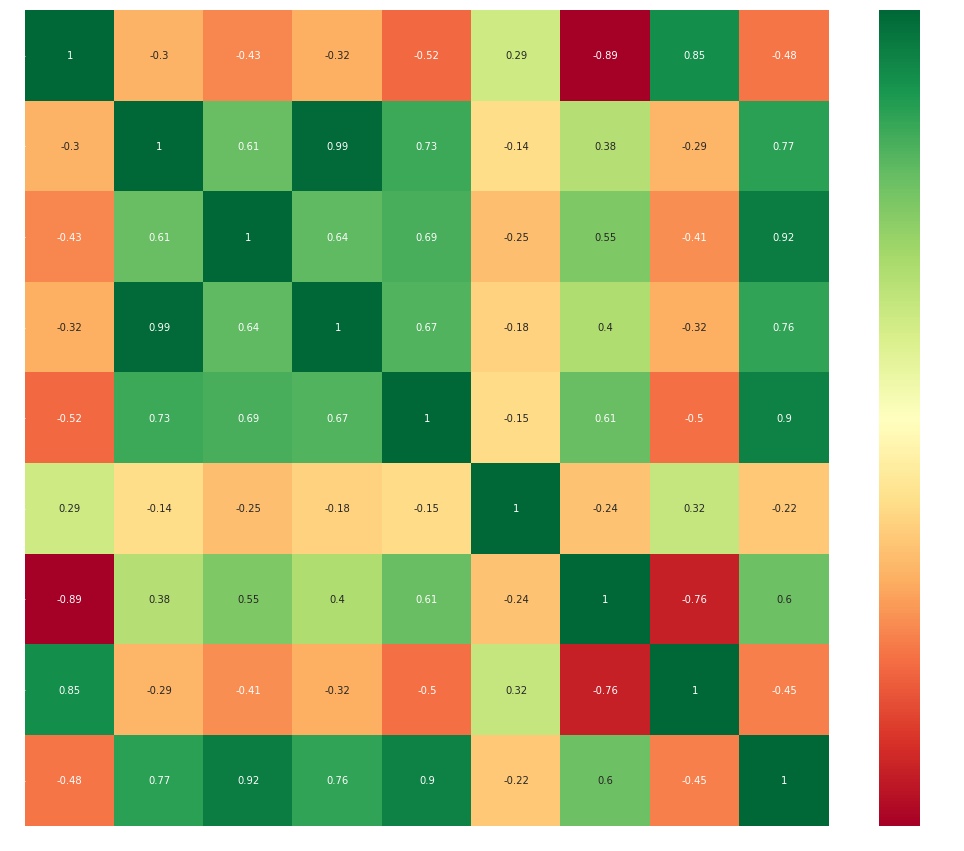

In [8]:
# Plotting the heatmap

plt.figure(figsize=(18, 15))
sns.heatmap(df[df.columns[1:]].corr(), annot=True, cmap="RdYlGn")
plt.show()

We can see that the data is multicollinear, therefore we could use PCA for dimensionality reduction

### Scaling the data for applying PCA

In [9]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(df[df.columns[1:]])

df_scaled = pd.DataFrame(scaled_data, columns=df.columns[1:])

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.411011,-0.565040,-0.432276,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.350191,-0.439218,-0.313677,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.318526,-0.484826,-0.353720,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,-0.291375,-0.532363,-0.345953,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,-0.104331,-0.178771,0.040735,0.101732,-0.601749,0.704258,-0.541946,-0.041817


### Applying PCA for dimensionality reduction

In [10]:
pca = PCA(random_state=71)
pc = pca.fit(df_scaled)

In [11]:
pc.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [12]:
# creating the principal components df

components_df = pd.DataFrame({"PC" + str(x + 1) : y for x, y in enumerate(pca.components_)})

components_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-0.316392,0.476267,-0.150012,-0.148052,0.101995,0.196585,0.761267,0.006444,-0.004951
1,0.342887,0.397311,-0.030574,0.449425,-0.038538,-0.038911,-0.013670,-0.055264,-0.717924
2,0.358535,0.155053,-0.075703,-0.599712,-0.493200,0.180699,-0.064616,0.430072,-0.130346
3,0.344865,0.370781,-0.072174,0.461798,-0.252787,-0.012180,0.027182,0.131135,0.665687
4,0.380041,0.128384,0.145764,-0.154806,0.794075,-0.038147,-0.023113,0.393811,0.079011
5,-0.143085,0.221261,0.948419,-0.007628,-0.136423,0.108403,-0.022077,-0.006070,0.011281
6,0.343857,-0.369820,0.196752,-0.018395,-0.154041,-0.586010,0.581208,0.002966,-0.031594
7,-0.302842,0.459715,-0.077834,-0.213928,-0.020336,-0.753901,-0.273145,0.034293,0.023682
8,0.399988,0.200624,0.010339,-0.364772,0.087501,0.045382,-0.044023,-0.799022,0.128464


In [13]:
components_df.index = df.columns[1:]

components_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
child_mort,-0.316392,0.476267,-0.150012,-0.148052,0.101995,0.196585,0.761267,0.006444,-0.004951
exports,0.342887,0.397311,-0.030574,0.449425,-0.038538,-0.038911,-0.013670,-0.055264,-0.717924
health,0.358535,0.155053,-0.075703,-0.599712,-0.493200,0.180699,-0.064616,0.430072,-0.130346
imports,0.344865,0.370781,-0.072174,0.461798,-0.252787,-0.012180,0.027182,0.131135,0.665687
income,0.380041,0.128384,0.145764,-0.154806,0.794075,-0.038147,-0.023113,0.393811,0.079011
inflation,-0.143085,0.221261,0.948419,-0.007628,-0.136423,0.108403,-0.022077,-0.006070,0.011281
life_expec,0.343857,-0.369820,0.196752,-0.018395,-0.154041,-0.586010,0.581208,0.002966,-0.031594
total_fer,-0.302842,0.459715,-0.077834,-0.213928,-0.020336,-0.753901,-0.273145,0.034293,0.023682
gdpp,0.399988,0.200624,0.010339,-0.364772,0.087501,0.045382,-0.044023,-0.799022,0.128464


In [15]:
# Looking at the explained variance of each PC

pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

In [16]:
# looking at the cumulative sum of the xplained variance

pca.explained_variance_ratio_.cumsum()

array([0.58937298, 0.77382467, 0.87293939, 0.93366217, 0.96395389,
       0.98855216, 0.9979496 , 0.99950602, 1.        ])

### Scree plot

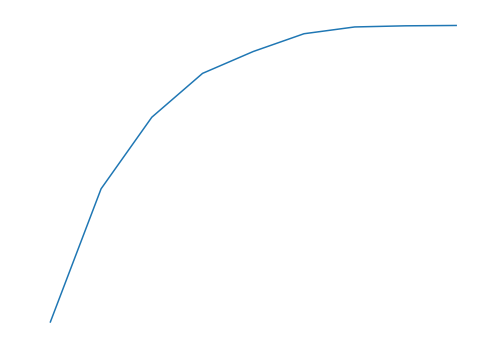

In [14]:
# Looking at the variance ratio of the pcs

plt.figure(figsize=(8, 6))
plt.plot([x for x in range(1, 10)], pca.explained_variance_ratio_.cumsum())
plt.show()

We can see from the scree plot that at 4 PCs the explained variance goes above 90%

#### Transforming the dataset using PCA

In [19]:
# Importing required libraries

from sklearn.decomposition import IncrementalPCA

In [21]:
# Using incremental PCA (4 components) and transforming the dataset

ipca = IncrementalPCA(n_components=4, batch_size=20)
pca_df = ipca.fit_transform(df_scaled)

In [23]:
pca_df[:10]

array([[-2.63663479,  1.47122539, -0.5467446 ,  0.24782732],
       [-0.02370308, -1.43518149, -0.00717987, -0.44187085],
       [-0.45913787, -0.67805625,  0.97157274, -0.16052487],
       [-2.72354539,  2.17593429,  0.59926147,  0.45540441],
       [ 0.648754  , -1.02683433, -0.24437514, -0.26034376],
       [ 0.03646458, -0.68355382,  1.46798025,  0.06692767],
       [-0.33410035, -1.2779633 ,  0.192912  , -0.50671878],
       [ 3.18446706, -0.2392749 , -0.16411152,  1.67144312],
       [ 3.81848354,  0.26294836, -0.29100472,  0.97223633],
       [-0.46776843, -0.49352333,  0.60345811, -0.28465062]])

In [24]:
# Preparing a dataframe from the transformed dataset

pca_dfm = pd.DataFrame(pca_df, columns=["PC1", "PC2", "PC3", "PC4"])

pca_dfm.head()

,PC1,PC2,PC3,PC4
0,-2.636635,1.471225,-0.546745,0.247827
1,-0.023703,-1.435181,-0.007180,-0.441871
2,-0.459138,-0.678056,0.971573,-0.160525
3,-2.723545,2.175934,0.599261,0.455404
4,0.648754,-1.026834,-0.244375,-0.260344


In [25]:
pca_dfm.shape

(167, 4)

In [27]:
# Adding the countries as a column to this dataframe

pca_dfm["Country"] = df["country"]

pca_dfm.head()

,PC1,PC2,PC3,PC4,Country
0,-2.636635,1.471225,-0.546745,0.247827,Afghanistan
1,-0.023703,-1.435181,-0.007180,-0.441871,Albania
2,-0.459138,-0.678056,0.971573,-0.160525,Algeria
3,-2.723545,2.175934,0.599261,0.455404,Angola
4,0.648754,-1.026834,-0.244375,-0.260344,Antigua and Barbuda


In [28]:
# Rearranging the columns of the df

cols = ["Country", "PC1", "PC2", "PC3", "PC4"]

pca_dfm = pca_dfm[cols]

pca_dfm.head()

,Country,PC1,PC2,PC3,PC4
0,Afghanistan,-2.636635,1.471225,-0.546745,0.247827
1,Albania,-0.023703,-1.435181,-0.007180,-0.441871
2,Algeria,-0.459138,-0.678056,0.971573,-0.160525
3,Angola,-2.723545,2.175934,0.599261,0.455404
4,Antigua and Barbuda,0.648754,-1.026834,-0.244375,-0.260344


Going ahead, KMeans clustering has to be used hence we will treat the outliers first

In [34]:
pca_dfm.describe()

,PC1,PC2,PC3,PC4
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-2.659217e-17,5.318434e-18,1.595530e-17,2.127373e-17
std,2.310042e+00,1.292234e+00,9.469984e-01,7.399854e-01
min,-3.939243e+00,-1.699971e+00,-1.824926e+00,-4.540317e+00
25%,-1.447517e+00,-9.808144e-01,-3.963362e-01,-3.521250e-01
50%,-3.572834e-01,-3.972908e-01,-1.808218e-01,-1.420279e-01
75%,8.499751e-01,6.784678e-01,2.671908e-01,2.238316e-01
max,1.263508e+01,8.225423e+00,7.883443e+00,3.186439e+00


#### Treating Outliers

In [29]:
# finding the percentages of outliers per column in the dataset
# based on z - score
# considered an outlier if zscore < -3 or z_score > 3

def get_outliers_percentage(df):
    
    numerics = ["float64", "int64"]
    
    num_df = df.select_dtypes(include=numerics)
    
    outliers_df = pd.DataFrame(columns=["Outliers", "Outlier_perc"])
    
    for col in num_df.columns:
        z_score = (df[col] - df[col].mean()) / df[col].std()
        is_outlier = np.where((z_score > 3) | (z_score < -3), 1, 0)
        perc = round((is_outlier.sum() / df.shape[0]) * 100, 2)
        outliers_df.loc[col] = [is_outlier.sum(), perc]
    
    return outliers_df

In [30]:
# outliers percentage

get_outliers_percentage(pca_dfm)

,Outliers,Outlier_perc
PC1,1.0,0.6
PC2,1.0,0.6
PC3,2.0,1.2
PC4,4.0,2.4


this indicates the presence of outliers, plotting the box plots for better analysis

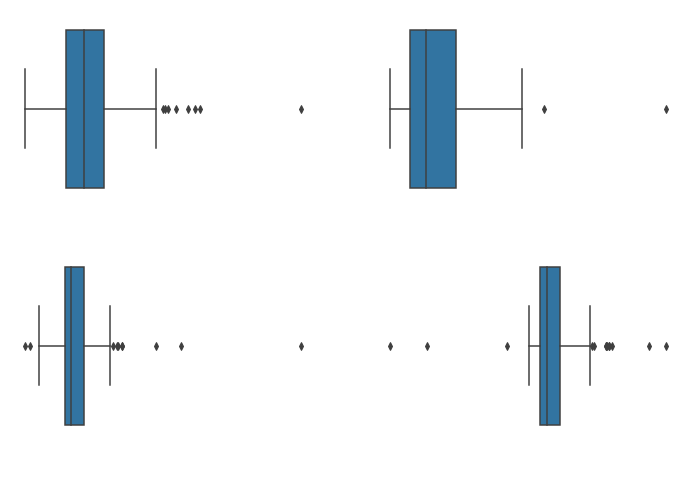

In [33]:
# Plotting the box plots for each PC

plt.figure(figsize=(12, 8))

for idx, col in enumerate(pca_dfm.columns[1:]):
    
    plt.subplot(2, 2, idx + 1)
    sns.boxplot(pca_dfm[col])

plt.show()

We will choose to cap the outliers between 5th and 95th percentile

In [35]:
# Using the quantile method for obtaining the caps

for col in pca_dfm.columns[1:]:
    
    q5 = pca_dfm[col].quantile(0.05)
    q95 = pca_dfm[col].quantile(0.95)
    
    pca_dfm.loc[pca_dfm[col] >= q95, col] = q95
    pca_dfm.loc[pca_dfm[col] <= q5, col] = q5

pca_dfm.describe()

,PC1,PC2,PC3,PC4
count,167.000000,167.000000,167.000000,167.000000
mean,-0.084591,-0.055463,-0.061793,0.012314
std,1.923875,1.066326,0.602972,0.462439
min,-2.760198,-1.352452,-1.120059,-0.520818
25%,-1.447517,-0.980814,-0.396336,-0.352125
50%,-0.357283,-0.397291,-0.180822,-0.142028
75%,0.849975,0.678468,0.267191,0.223832
max,3.918711,2.174962,1.184312,1.151280


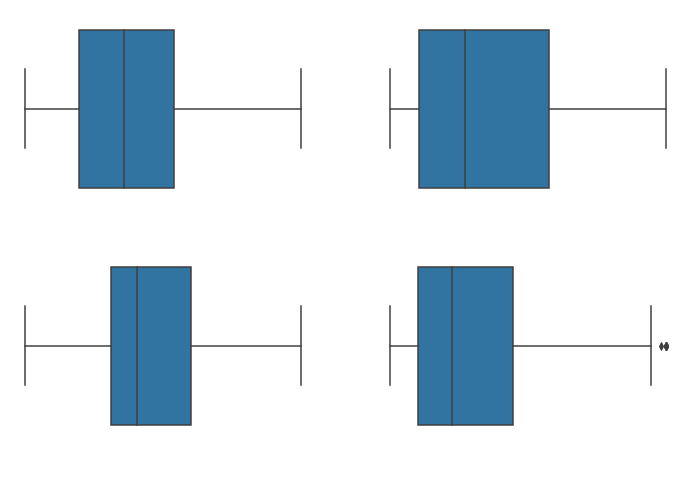

In [36]:
# Plotting the box plots again

plt.figure(figsize=(12, 8))

for idx, col in enumerate(pca_dfm.columns[1:]):
    
    plt.subplot(2, 2, idx + 1)
    sns.boxplot(pca_dfm[col])

plt.show()

Looks like PC4 still has outliers

In [42]:
# Looking at different quantiles of PC4

pca_dfm["PC4"].describe(percentiles=[0.91, 0.92, 0.93, 0.94, 0.95, 0.97, 0.99])

count    167.000000
mean       0.012314
std        0.462439
min       -0.520818
50%       -0.142028
91%        0.785001
92%        0.956273
93%        0.979470
94%        1.059198
95%        1.141448
97%        1.151280
99%        1.151280
max        1.151280
Name: PC4, dtype: float64

In [43]:
# Calculating the IQR for PC4

Q3 = pca_dfm["PC4"].quantile(0.75)
Q1 = pca_dfm["PC4"].quantile(0.25)

IQR = Q3 - Q1

IQR

0.5759565749415929

#### Modelling

In [81]:
# Importing the necessary libraries

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [82]:
# Initializing the modeller
# Kmeans with some arbitrary K

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(data)

KMeans(max_iter=50, n_clusters=4)

In [83]:
kmeans.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 1,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 3, 0, 2, 2, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 3, 0, 1, 2, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2])

#### Finding the optimum no. of clusters

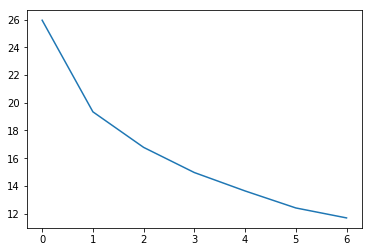

In [84]:
# Plotting the elbow curve

nums = [2, 3, 4, 5, 6, 7, 8]

SSD = []

for i in nums:
    kmeans = KMeans(n_clusters=i, max_iter=50)
    kmeans.fit(data)
    
    SSD.append(kmeans.inertia_)

plt.plot(SSD)
plt.show()

In [85]:
# Calculating the silhouette scores for each number of clusters

for i in nums:
    kmeans = KMeans(n_clusters=i, max_iter=50)
    kmeans.fit(data)
    
    cluster_labels = kmeans.labels_
    
    sil_avg = silhouette_score(df_scaled, cluster_labels)
    
    print("for {0} number of clusters, the silhouette score is {1}".format(i, sil_avg))
    

for 2 number of clusters, the silhouette score is 0.37902922788692567
for 3 number of clusters, the silhouette score is 0.34265474105126204
for 4 number of clusters, the silhouette score is 0.34600192038431477
for 5 number of clusters, the silhouette score is 0.24153171026947448
for 6 number of clusters, the silhouette score is 0.2627694497760151
for 7 number of clusters, the silhouette score is 0.2518267356472801
for 8 number of clusters, the silhouette score is 0.23567564935794003


As we can see here that the silhouette scores are bad for clusters without any outlier treatment and we haven't even selected the Key indicators of the data